# Assignment 4: Modeling Epidemics

In [85]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy
import EoN as eon
from tqdm import tqdm
from scipy.optimize import curve_fit
from scipy import stats


from sklearn.linear_model import LinearRegression

## Part 1: Outbreak Modeling [40 Points]

In [10]:
def drop_weights(G):
    '''Drop the weights from a networkx weighted graph.'''
    for node, edges in nx.to_dict_of_dicts(G).items():
        for edge, attrs in edges.items():
            attrs.pop('weight', None)

def load_flu_network():
    # Read the graph
    G = nx.read_edgelist("fludata.txt", nodetype=int, data=(("weight", float),)).to_undirected()
    drop_weights(G)

    return G

In [11]:
G = load_flu_network()

In [12]:
G.edges(data=True)

EdgeDataView([(1, 11, {}), (1, 37, {}), (1, 90, {}), (1, 137, {}), (1, 155, {}), (1, 158, {}), (1, 163, {}), (1, 186, {}), (1, 235, {}), (1, 237, {}), (1, 242, {}), (1, 244, {}), (1, 268, {}), (1, 275, {}), (1, 296, {}), (1, 300, {}), (1, 312, {}), (1, 317, {}), (1, 325, {}), (1, 335, {}), (1, 358, {}), (1, 361, {}), (1, 364, {}), (1, 394, {}), (1, 404, {}), (1, 412, {}), (1, 431, {}), (1, 445, {}), (1, 448, {}), (1, 454, {}), (1, 461, {}), (1, 474, {}), (1, 520, {}), (1, 540, {}), (1, 560, {}), (1, 562, {}), (1, 571, {}), (1, 577, {}), (1, 604, {}), (1, 619, {}), (1, 623, {}), (1, 636, {}), (1, 638, {}), (1, 656, {}), (1, 686, {}), (1, 695, {}), (1, 711, {}), (1, 712, {}), (1, 716, {}), (1, 723, {}), (1, 735, {}), (1, 745, {}), (1, 750, {}), (1, 782, {}), (1, 787, {}), (11, 7, {}), (11, 8, {}), (11, 9, {}), (11, 12, {}), (11, 15, {}), (11, 21, {}), (11, 22, {}), (11, 28, {}), (11, 30, {}), (11, 32, {}), (11, 33, {}), (11, 39, {}), (11, 41, {}), (11, 44, {}), (11, 48, {}), (11, 50, {})

### 1.1

In [32]:
def simulate_outbreak(G, n_iter, initial_infected=325, tmax=10, beta=0.01, mu=0.5):
    '''
    Inputs:
        G: nx.Graph
        n_iter: int
        initial_infected: int
        tmax: int
        beta: float
        mu: float

    Returns:
        simulation_runs: list[tuple]
    '''

    simulation_runs = []
    
    for _ in range(n_iter):
        t, S, I = eon.fast_SIS(G, beta, mu, initial_infecteds=[initial_infected], tmax=tmax)
        
        if np.sum(I[-1]) != 0:
            simulation_runs.append((t, I, S))



    return simulation_runs

def plot_outbreaks(simulation_runs, save=False):
    '''
    Inputs:
        simulation_runs: list[tuple]
        save: bool
    '''

    plt.figure(figsize=(10, 6))
    
    for i, (t, I, S) in enumerate(simulation_runs):
        plt.plot(range(len(I)), I, label=f"Simulation {i+1} - Infected")
        plt.plot(range(len(S)), S, label=f"Simulation {i+1} - Susceptible")
    
    plt.xlabel("Time")
    plt.ylabel("Number of Nodes")
    plt.title("Outbreak Simulation")
    plt.legend()
    plt.grid(True)


    if save:
        plt.savefig('1_1.png')

    plt.show()

In [26]:
G = load_flu_network()

# Generate 10 simulation runs for plotting
simulation_runs = simulate_outbreak(G, 10)

In [27]:
simulation_runs[0]

(array([0.00000000e+00, 7.82467276e-03, 3.43826725e-01, ...,
        9.99415465e+00, 9.99654727e+00, 9.99820256e+00]),
 array([  1,   2,   3, ..., 647, 646, 647]),
 array([787, 786, 785, ..., 141, 142, 141]))

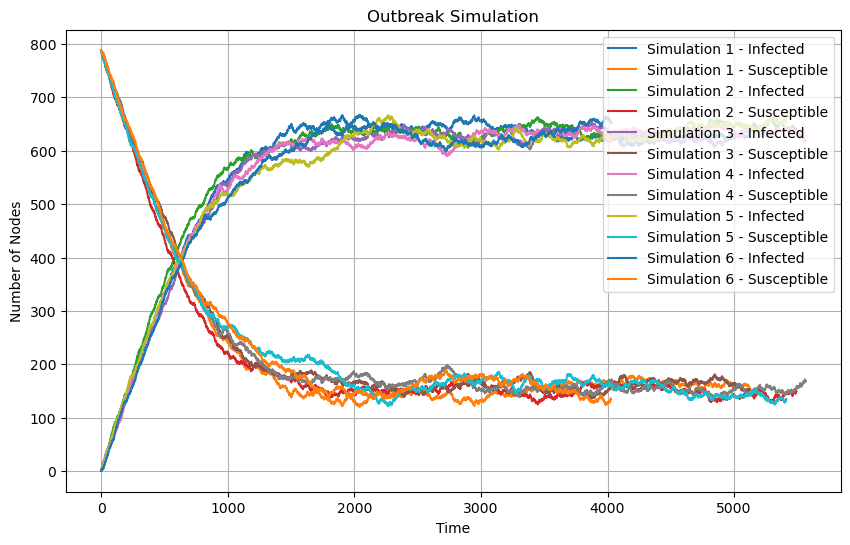

In [20]:
plot_outbreaks(simulation_runs)

In [22]:
t, I = simulation_runs[0]

In [23]:
t

array([  1,   2,   3, ..., 637, 638, 637])

In [24]:
I

array([787, 786, 785, ..., 151, 150, 151])

### 1.2

In [28]:
def get_exponent(simulation_run, I_thrsh=100):
    '''
    Inputs:
        simulation_run: tuple
        I_thrsh: int

    Returns:
        tau: float
    '''
    t, I, _ = simulation_run

    # Select the time and infected arrays where I <= I_thrsh
    t_selected = t[I <= I_thrsh]
    I_selected = I[I <= I_thrsh]

    # Define the exponential function
    exponential_func = lambda t, tau: np.exp(t / tau)

    # Fit the exponential function to the data
    popt, pcov = curve_fit(exponential_func, t_selected, I_selected)

    # Retrieve the estimated time constant tau
    tau = popt[0]

    return tau

def plot_curve_fit(simulation_run, tau, I_thrsh=100, save=False):
    '''
    Inputs:
        simulation_run: tuple
        tau: float
        I_thrsh: int
        save: bool
    '''

    t, I, _ = simulation_run

    # Select the time and infected arrays where I <= I_thrsh
    t_selected = t[I <= I_thrsh]
    I_selected = I[I <= I_thrsh]

    # Define the exponential function
    exponential_func = lambda t, tau: np.exp(t / tau)

    # Generate the theoretical curve using the estimated tau
    I_theoretical = exponential_func(t_selected, tau)

    # Plot the actual number of infected and theoretical curve
    plt.plot(t, I, label='Actual')
    plt.plot(t_selected, I_theoretical, label='Theoretical')

    # Calculate r-squared between the curves
    ss_res = np.sum((I_selected - I_theoretical) ** 2)
    ss_tot = np.sum((I_selected - np.mean(I_selected)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    # Add title and legend to the plot
    plt.title(f"Estimated tau: {tau:.2f}, R-squared: {r_squared:.2f}")
    plt.legend()



    if save:
        plt.savefig('1_2.png')

    plt.show()

### 1.3

In [59]:
def calculate_theoretical_taus(G, beta=0.01, mu=0.5):
    '''
    Inputs:
        G: nx.Graph
        beta: float
        mu: float

    Returns:
        tau_rand: float
        tau_slide: float
        tau_book: float
    '''
    # Random distribution
    tau_rand = 1 / (2 * beta * G.number_of_edges())

    # Arbitrary distribution from lecture
    degree_sequence = [d for _, d in G.degree()]
    tau_slide = 1 / (2 * beta * np.mean(degree_sequence))

    # Arbitrary distribution from textbook
    largest_eigenvalue = max(nx.adjacency_spectrum(G))
    tau_book = 1 / (beta * largest_eigenvalue)


    return tau_rand, np.real(tau_slide), np.real(tau_book)

def compare_taus(empirical_taus, tau_rand, tau_slide, tau_book, save=False):
    '''
    Inputs:
        empirical_taus: list[float]
        tau_rand: float
        tau_slide: float
        tau_book: float
        save: bool
    '''

    # Create a list of theoretical taus
    theoretical_taus = [tau_rand, tau_slide, tau_book]

    # Combine empirical taus with theoretical taus
    all_taus = empirical_taus + theoretical_taus

    # Plot the boxplot
    plt.boxplot(all_taus)

    # Add dots for theoretical taus
    x_positions = np.arange(1, len(theoretical_taus) + 1)
    plt.plot(x_positions, theoretical_taus, 'ro')

    # Set labels and title
    plt.xlabel('Theoretical Distribution')
    plt.ylabel('tau')
    plt.title('Comparison of Theoretical and Empirical tau')




    if save:
        plt.savefig('1_3.png')

    plt.show()


In [41]:
rand,slide,book=calculate_theoretical_taus(G)

In [54]:
np.real(slide)

0.16653845178415938

In [61]:
rand

0.0004226864258481203

In [63]:
np.real(book)

0.2967430458335016

### 1.4

In [66]:

def calculate_theoretical_endemic_size(G, beta=0.01, mu=0.5):
    '''
    Inputs:
        G: nx.Graph
        beta: float
        mu: float

    Returns:
        theoretical_endemic_size: int
    '''
    

    largest_eigenvalue = max(nx.adjacency_spectrum(G))
    theoretical_endemic_size = int((1 - mu / beta) / largest_eigenvalue * G.number_of_nodes())



    return theoretical_endemic_size

def compare_endemic_sizes(empirical_endemic_sizes, theoretical_endemic_size, save=False):
    '''
    Inputs:
        empirical_endemic_sizes: list[int]
        theoretical_endemiz_size: int
        save: bool
    '''


    # Combine empirical endemic sizes with theoretical endemic size
    all_endemic_sizes = empirical_endemic_sizes + [theoretical_endemic_size]

    # Plot the boxplot
    plt.boxplot(all_endemic_sizes)
    
    plt.plot(2, theoretical_endemic_size, 'ro', label='Theoretical')

    # Set labels and title
    plt.xlabel('Distribution')
    plt.ylabel('Endemic Size')
    plt.title('Comparison of Empirical and Theoretical Endemic Sizes')


    if save:
        plt.savefig('1_4.png')

    plt.show()

### 1.5

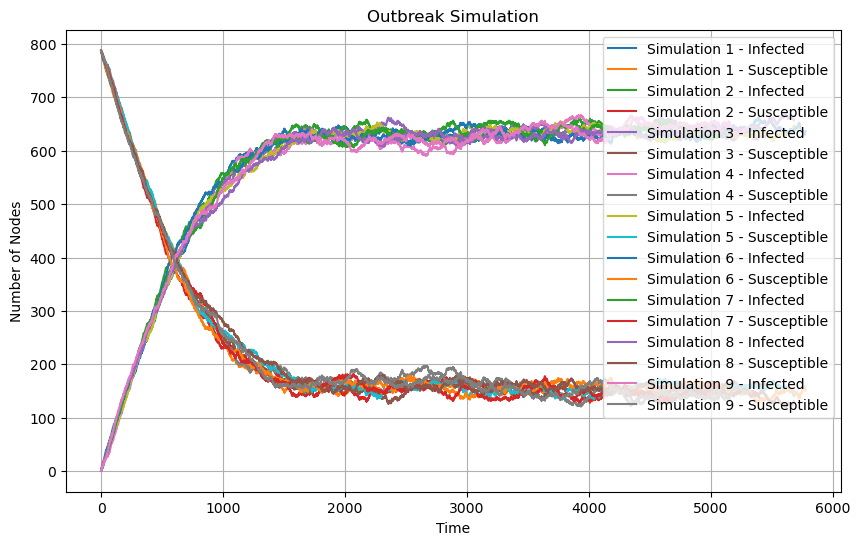

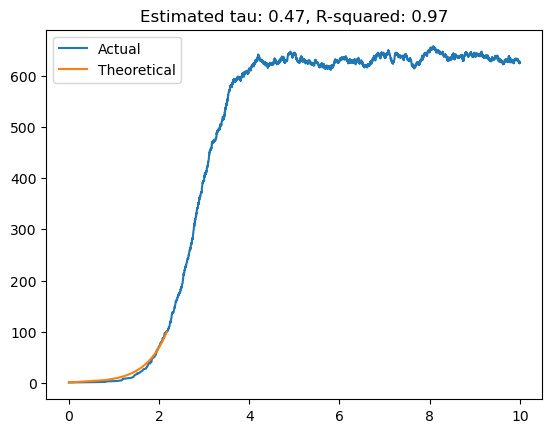

/Users/johnfunk/opt/anaconda3/envs/networks/lib/python3.9/site-packages/networkx/linalg/spectrum.py:110: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return sp.linalg.eigvals(nx.adjacency_matrix(G, weight=weight).todense())


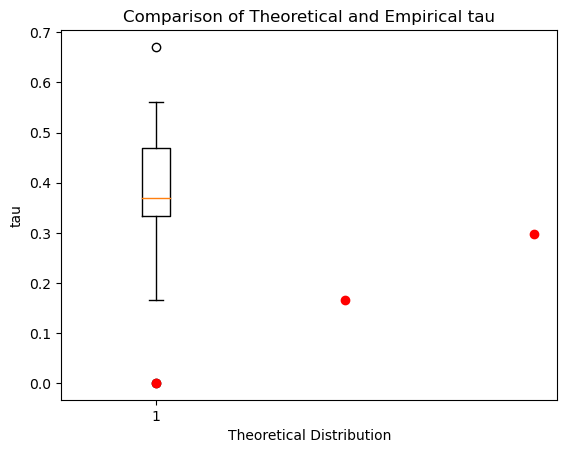

/Users/johnfunk/opt/anaconda3/envs/networks/lib/python3.9/site-packages/networkx/linalg/spectrum.py:110: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return sp.linalg.eigvals(nx.adjacency_matrix(G, weight=weight).todense())
/var/folders/51/n64xxfwj1k1797dd7bfbl6kr0000gn/T/ipykernel_56015/496849552.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  theoretical_endemic_size = int((1 - mu / beta) / largest_eigenvalue * G.number_of_nodes())


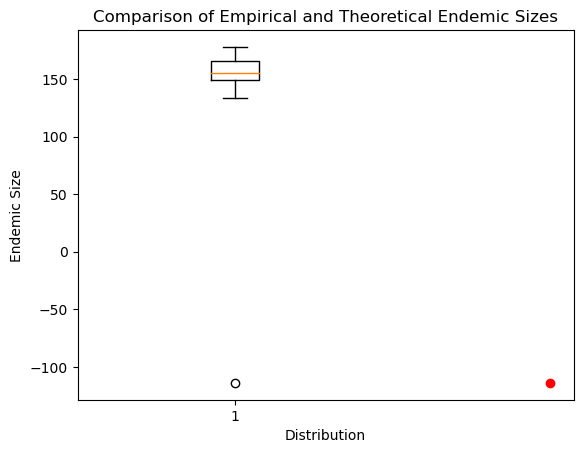

In [67]:
G = load_flu_network()

# Generate 10 simulation runs for plotting
simulation_runs = simulate_outbreak(G, 10)

plot_outbreaks(simulation_runs)

tau = get_exponent(simulation_runs[0])
plot_curve_fit(simulation_runs[0], tau)

simulation_runs = simulate_outbreak(G, 25)

empirical_taus = []
empirical_endemic_sizes = []
for run in simulation_runs:
    empirical_taus.append(get_exponent(run))
    empirical_endemic_sizes.append(run[2][-1])

tau_rand, tau_slide, tau_book = calculate_theoretical_taus(G)

compare_taus(empirical_taus, tau_rand, tau_slide, tau_book)

theoretical_endemic_size = calculate_theoretical_endemic_size(G)

compare_endemic_sizes(empirical_endemic_sizes, theoretical_endemic_size)

### 1.5 Written Response

Answer: The exponential curve has a very good fit in 1.2. The theoretical estimates in 1.3 and 1.4 do not really match the empirical data very well. The one that most fits the data is the arbitrary distribution from the text book for 1.3

## Part 2: Transmission Rate Variation  $\beta$ [25 Points]

### 2.1 Minimum Transmission Rate for Epidemic

In [71]:
def simulate_beta_sweep(G, n_iter, beta_min=0.001, beta_max=0.04, beta_samples=40, 
                        initial_infected=325, tmax=10, mu=0.5):
    '''
    Inputs:
        G: nx.Graph
        n_iter: int
        beta_min: float
        beta_max: float
        beta_samples: int
        initial_infect: int
        tmax: int
        mu: float

    Returns:
        beta_runs: list[list[tuple]]
    '''


    beta_values = np.linspace(beta_min, beta_max, beta_samples)
    beta_runs = []

    for beta in beta_values:
        runs = []
        for _ in range(5):
            simulation_run = simulate_outbreak(G, n_iter, initial_infected, tmax, beta, mu)
            if simulation_run and simulation_run[-1][0][-1] > 0:
                runs.append(simulation_run)
        beta_runs.append(runs)




    return beta_runs

def extract_average_tau(beta_runs):
    '''
    Inputs:
        beta_runs: list[list[tuple]]

    Returns:
        avg_taus: list[float]
    '''


    avg_taus = []
    
    for runs in beta_runs:
        taus = []
        for run in runs:
            taus.append(get_exponent(run))
        avg_taus.append(np.mean(taus))



    return avg_taus


def plot_beta_tau_curves(avg_taus, t, save=False):
    '''
    Inputs:
        avg_taus: list[float]
        t: list[float]
        save: bool
    '''

    plt.plot(t, avg_taus, 'bo-', label='Simulation')
    plt.xlabel('Transmission Rate (beta)')
    plt.ylabel('Average Tau')
    plt.title('Beta vs. Average Tau')
    plt.yscale('log')
    plt.legend()


    
    if save:
        plt.savefig('2_1.png')

    plt.show()


### 2.2

In [69]:
def extract_average_end(beta_runs):
    '''
    Inputs:
        beta_runs: list[list[tuple]]
    
    Returns:
        avg_ends: list[float]
    '''

    avg_ends = []
    
    for runs in beta_runs:
        ends = []
        for run in runs:
            ends.append(run[-1][1])
        avg_ends.append(np.mean(ends))



    return avg_ends

def calculate_theoretical_endemic(G, beta_min=0.001, beta_max=0.04, 
                                  beta_samples=40, mu=0.5):
    '''
    Inputs:
        G: nx.Graph
        beta_min: float
        beta_max: float
        beta_samples: int
        mu: float

    Returns:
        theoretical_endemics: list[float]
        rand_dist_min_beta: float
        arb_dist_min_beta: float
    '''
    

    betas = np.linspace(beta_min, beta_max, beta_samples)
    theoretical_endemics = []
    rand_dist_min_beta = None
    arb_dist_min_beta = None
    
    for beta in betas:
        p = beta / (beta + mu)
        q = mu / (beta + mu)
        theoretical_endemics.append(p / (p + q))
        
        if rand_dist_min_beta is None and p == q:
            rand_dist_min_beta = beta
        
        if arb_dist_min_beta is None and p < q:
            arb_dist_min_beta = beta



    return theoretical_endemics, rand_dist_min_beta, arb_dist_min_beta

def compare_endemic_sizes_vs_beta(avg_ends, theoretical_endemic_sizes, 
                                  rand_dist_min_beta, arb_dist_min_beta,
                                  beta_min=0.001, beta_max=0.04, beta_samples=40,
                                  save=False):
    '''
    Inputs:
        avg_ends: list[float]
        theoretical_endemic_sizes: list[float]
        rand_dist_min_beta: float
        arb_dist_min_beta: float
        beta_min: float
        beta_max: float
        beta_samples: int
        save: bool
    '''


    betas = np.linspace(beta_min, beta_max, beta_samples)
    
    plt.plot(betas, avg_ends, 'bo-', label='Simulation')
    plt.plot(betas, theoretical_endemic_sizes, 'r--', label='Theoretical')
    plt.axvline(rand_dist_min_beta, color='g', linestyle='--', label='Random Dist Min Beta')
    plt.axvline(arb_dist_min_beta, color='m', linestyle='--', label='Arbitrary Dist Min Beta')
    
    plt.xlabel('Transmission Rate (beta)')
    plt.ylabel('Endemic Size')
    plt.title('Endemic Size vs. Beta')
    plt.legend()



    if save:
        plt.savefig('2_2.png')

    plt.show()


### 2.3

In [72]:
### 2.1
beta_runs = simulate_beta_sweep(G, 5, beta_samples=20)

avg_taus = extract_average_tau(beta_runs)

plot_beta_tau_curves(avg_taus, t=beta_runs[0][0][0])

### 2.2
avg_ends = extract_average_end(beta_runs)

theoretical_endemics, rand_dist_min_beta, arb_dist_min_beta = calculate_theoretical_endemic(G, beta_samples=20)

compare_endemic_sizes_vs_beta(avg_ends, theoretical_endemics, rand_dist_min_beta, arb_dist_min_beta, beta_samples=20)

ValueError: not enough values to unpack (expected 3, got 1)

In [76]:
beta_runs[2]

[[(array([0.        , 0.07499862, 0.12217671, ..., 9.99356446, 9.99421698,
          9.99606395]),
   array([  1,   2,   3, ..., 492, 491, 490]),
   array([787, 786, 785, ..., 296, 297, 298])),
  (array([0.        , 0.69833815, 0.91186762, ..., 9.99693462, 9.99754462,
          9.99944582]),
   array([  1,   2,   3, ..., 491, 492, 493]),
   array([787, 786, 785, ..., 297, 296, 295])),
  (array([0.        , 0.2393962 , 0.24491116, ..., 9.99631926, 9.99634399,
          9.99955022]),
   array([  1,   2,   3, ..., 525, 526, 525]),
   array([787, 786, 785, ..., 263, 262, 263]))],
 [(array([0.        , 0.60400252, 1.21336871, ..., 9.99190145, 9.99407614,
          9.99531974]),
   array([  1,   2,   3, ..., 498, 499, 500]),
   array([787, 786, 785, ..., 290, 289, 288])),
  (array([0.        , 0.10316336, 0.35771957, ..., 9.99428946, 9.99485574,
          9.99554453]),
   array([  1,   2,   1, ..., 505, 504, 503]),
   array([787, 786, 787, ..., 283, 284, 285])),
  (array([0.        , 0.09357

### 2.3 Written Response

Answer: 

## Part 3
### 3.1 

In [91]:
def sweep_initial_infected(G, tmax=10, beta=0.01, mu=0.5):
    '''
    Inputs:
        G: nx.Graph
        tmax: int
        beta: float
        mu: float
    Returns:
        taus: list[float]
        nodes: list[int]
    '''


    taus = []
    nodes = []
    for node in G.nodes:
        simulation_run = simulate_outbreak(G, 1, initial_infected=node, tmax=tmax, beta=beta, mu=mu)
        if len(simulation_run) > 0:
            taus.append(simulation_run[-1][0])
            nodes.append(node)




    return taus, nodes

# Compute centrality metrics
def compute_centrality(G, nodes):
    '''
    Inputs:
        G: nx.Graph
        nodes: list[int]

    Returns:
        cent_dict: dict[list[float]]
    '''

    deg_cen = nx.degree_centrality(G)
    clo_cen = nx.closeness_centrality(G, wf_improved=False)
    bet_cen = nx.betweenness_centrality(G)
    eig_cen = nx.eigenvector_centrality(G)
    cent_dict = {'deg': [deg_cen[node] for node in nodes],
                 'clo': [clo_cen[node] for node in nodes],
                 'bet': [bet_cen[node] for node in nodes],
                 'eig': [eig_cen[node] for node in nodes]}




#     cent_dict = {'deg': deg_cen, 'clo': clo_cen, 'bet': bet_cen, 'eig': eig_cen}
    return cent_dict

### 3.2

In [83]:
def calculate_person_correlation(taus, cent_dict):
    '''
    Inputs:
        taus: list[float]
        cent_dict: dict[list[float]]

    Returns:
        r_dict: dict[list[float]]
    '''


    r_dict = {}
    for centrality_type,centrality_values in cent_dict.items():
        r, p_value = stats.pearsonr(taus, centrality_values)
        r_dict[centrality_type] = {'r': r, 'p_value': p_value}



#     r_dict = {'deg': r_deg, 'clo': r_clo, 'bet': r_bet, 'eig': r_eig} 
    return r_dict

    
def plot_centrality_vs_tau(taus, nodes, cent_dict, r_dict, save=False):
    '''
    Inputs:
        taus: list[float]
        nodes: list[int]
        cent_dict: dict[list[float]]
        r_dict: dict[list[float]]
        save: bool
    '''
    

    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    centrality_labels = {'deg': 'Degree Centrality', 'clo': 'Closeness Centrality',
                         'bet': 'Betweenness Centrality', 'eig': 'Eigenvector Centrality'}

    for i, centrality_type in enumerate(['deg', 'clo', 'bet', 'eig']):
        ax = axs[i // 2, i % 2]
        centrality_values = cent_dict[centrality_type]
        r = r_dict[centrality_type]['r']
        p_value = r_dict[centrality_type]['p_value']

        ax.scatter(centrality_values, taus)
        ax.set_xlabel(centrality_labels[centrality_type])
        ax.set_ylabel('𝜏')
        ax.set_title(f'Pearson Correlation: r = {r:.3f}, p-value = {p_value:.3f}')

    plt.tight_layout()





    if save:
        plt.savefig('3_2.png')

    plt.show()

### 3.3

In [92]:
G = load_flu_network()

taus, nodes = sweep_initial_infected(G)
cent_dict = compute_centrality(G, nodes)

r_dict = calculate_person_correlation(taus, cent_dict)
plot_centrality_vs_tau(taus, nodes, cent_dict, r_dict)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (625,) + inhomogeneous part.

In [99]:
len(taus)

625

In [97]:
len(set(cent_dict['deg']))

273

In [105]:
for centrality_type,centrality_values in cent_dict.items():
    print(centrality_type)
    print(len(centrality_values))

deg
625
clo
625
bet
625
eig
625


### 3.3 Written Response

Answer:

## Part 4: Knowledge Question [5 Points]

Answer: Show that it satisfies the submodularity property.

Set of submodular functions {f_i} for i = 1, 2, ..., n, non-negative weights {w_i} for i = 1, 2, ..., n. Define a new function f as the non-negative linear combination of the submodular functions:

f(S) = ∑(w_i * f_i(S))

S is a subset of the ground set.

Show that it satisfies the diminishing returns property:

For any sets A ⊆ B and any element x outside B, the marginal gain of adding x to A is greater than or equal to the marginal gain of adding x to B:

f(A ∪ {x}) - f(A) ≥ f(B ∪ {x}) - f(B)

Inequality:

f(A ∪ {x}) - f(A) = ∑(w_i * f_i(A ∪ {x}) - w_i * f_i(A))
= ∑(w_i * (f_i(A) + f_i({x} \ A)) - w_i * f_i(A))
= ∑(w_i * f_i({x} \ A))


f(B ∪ {x}) - f(B) = ∑(w_i * f_i({x} \ B))

Show that ∑(w_i * f_i({x} \ A)) ≥ ∑(w_i * f_i({x} \ B)).

Since each f_i is a submodular function, we have f_i({x} \ A) ≥ f_i({x} \ B) for all i.

Multiplying both sides of the inequality by the non-negative weights w_i and summing over all i, we get:

∑(w_i * f_i({x} \ A)) ≥ ∑(w_i * f_i({x} \ B))

The non-negative linear combination of submodular functions, f(S) = ∑(w_i * f_i(S)), satisfies the diminishing returns property is a submodular function

(You can do this proof as markdown here or upload an image of the proof on paper. If you upload an image make sure to include the image file with your submission)